In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random
import itertools



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA


import antares_client

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# set random seed for consistent results
import random
random.seed(0)

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [2]:
#TODO: add more suffixes and make plots!
# Specifically with nohostdownweighted and see...

In [3]:
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_addJiterNorm0p05" #
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_addJiterNorm0p02" #

#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_addJiterNorm0p01" #
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20_addJiterNorm0p1" # need smaller jitter
#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" # !! Really nice. Same/better results with less PCs. 98% var.
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20" #really v good, better than 35pca (best PC implementation)

#suffix="noTNScut_pca35_noCadence_NOtransf_HasHostGalOnly_MaxAbs_AlerceCls_fw_MI_classif_direct_output_SMOTE_80-20"

#suffix="noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_SMOTE_80-20" # amazing sim search. 99%var. AD is quite good, maybe 2nd or 3rd best. Maybe overall best when considering both!
suffix="noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_SMOTE_80-20_v2" # amazing sim search. 99%var. AD is quite good, maybe 2nd or 3rd best. Maybe overall best when considering both!


In [4]:
dataset_bank_pca = pd.read_csv(f'../dataframes/{suffix}_dataset_bank_pca.csv', compression='gzip', index_col=0)
dataset_bank_test = pd.read_csv(f'../dataframes/{suffix}_dataset_bank_pca_test.csv', compression='gzip', index_col=0)
dataset_bank_orig = pd.read_pickle('../dataframes/dataset_label_orig_SMOTE_train_test_80-20_v2.pkl')

#dataset_bank_orig = pd.read_pickle('../dataframes/dataset_label_orig_SMOTE_train_test_80-20_addJiterNorm0p02.pkl')

full_ann_properties_df = pd.read_csv(f'../dataframes/full_ann101_properties_df_{suffix}.csv', index_col=0)
#full_ann_properties_df = pd.read_csv(f'../dataframes/full_ann_properties_df_{suffix}.csv', index_col=0)


In [5]:
dataset_bank_test['tns_cls'] = full_ann_properties_df['ann=0_tns_cls']

dataset_bank_pca['tns_cls'] = dataset_bank_orig
dataset_bank_pca

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,tns_cls
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21abcmhms,-2.618010,3.101223,-1.272259,-4.555363,-3.731741,-3.357922,1.722349,-0.580492,-1.208102,0.588442,...,0.849600,0.635591,-0.545805,-0.008517,0.033224,0.347322,0.002545,-0.219727,-0.633905,None
ZTF21abainqp,-5.128817,4.634740,-0.801267,0.417822,0.168451,-1.280300,2.945998,0.483734,-4.979452,-2.381233,...,-0.155221,0.621046,-0.776170,-0.088206,0.858698,-0.242308,0.237940,-1.396466,-0.276406,None
ZTF21aaridax,2.275069,2.746021,3.008403,-1.341203,0.141348,-2.952774,-0.546145,-0.493252,-0.211812,-3.257987,...,0.306989,-0.776864,0.169583,0.530523,0.755163,0.275757,0.576954,-0.431170,-0.195476,None
ZTF21aapvxnf,3.017555,-3.971263,3.933624,-0.429877,0.377237,-0.239121,0.771743,-0.538988,1.086094,-3.241897,...,0.523415,-0.601620,-0.059211,0.405983,0.033325,-0.639506,1.011910,-0.190511,0.355964,SN Ia-91T-like
ZTF21aalcsng,5.535767,0.125920,3.475390,1.675018,2.078891,-0.708436,0.716045,-1.590875,-0.033163,-4.426463,...,0.923188,-0.858212,0.617671,-0.117519,0.015858,-0.601603,0.465060,-0.469666,0.684238,SN Ia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTFabc57346,-2.793441,-6.191856,0.458156,3.499652,-1.692475,-1.199031,-1.153840,2.284008,-0.438880,0.101026,...,-0.031921,-0.003364,0.037026,0.096027,-0.141284,0.095847,0.265543,0.045157,0.030600,TDE
ZTFabc03958,-8.023225,4.275164,-2.395833,2.270975,2.154283,-0.545712,3.905063,2.579053,0.440769,-0.943250,...,0.108007,0.004680,0.051115,-0.308392,-0.134645,0.018735,-0.093035,0.129914,0.275631,TDE
ZTFabc87304,-10.789237,3.778423,1.770247,0.601057,2.117121,-2.727727,0.664182,2.854027,-1.737502,-0.772243,...,0.005984,0.086701,0.139600,0.414217,0.177791,-0.274739,0.128488,-0.122538,-0.129984,TDE


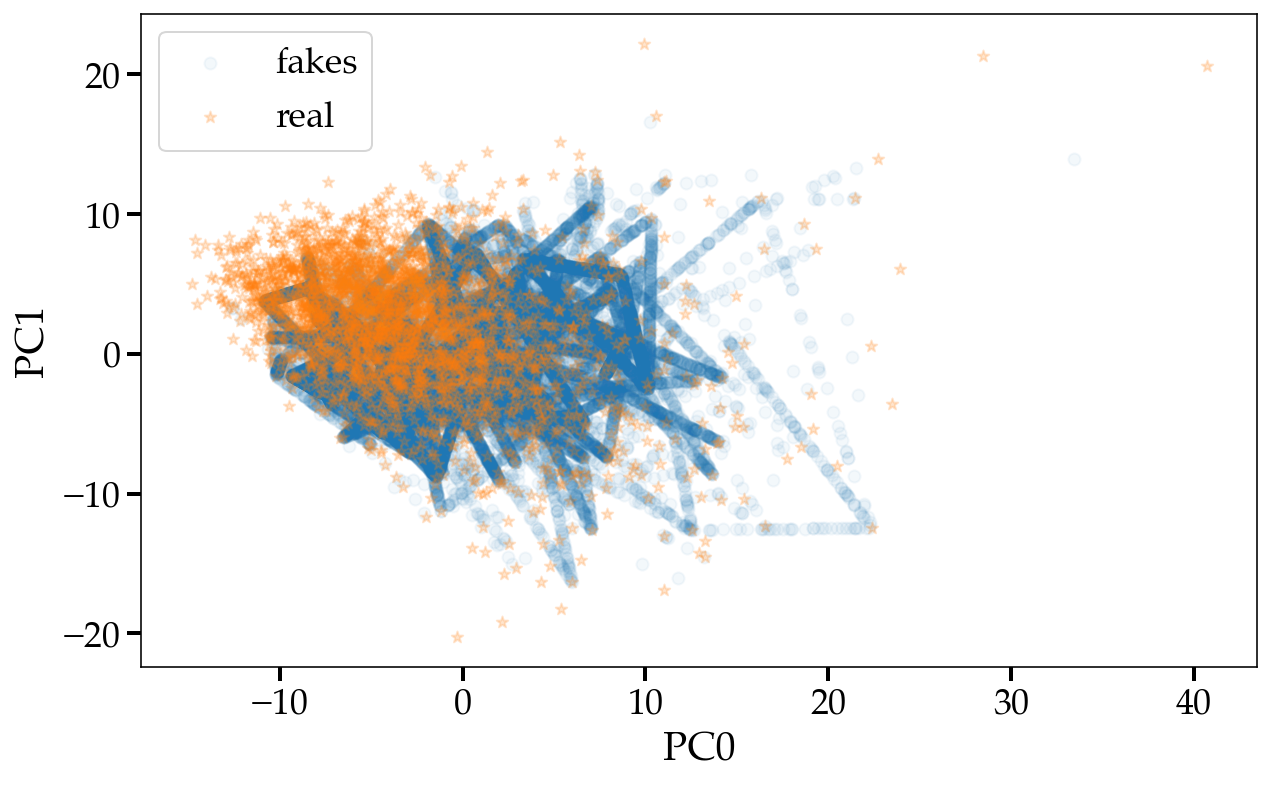

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

# Split into real/fakes
real_df = dataset_bank_pca[~dataset_bank_pca.index.str.startswith('ZTFabc')]
fakes_df = dataset_bank_pca[dataset_bank_pca.index.str.startswith('ZTFabc')]

ax.scatter(fakes_df['PC0'], fakes_df['PC1'], alpha=0.05, marker='o', label='fakes')
ax.scatter(real_df['PC0'], real_df['PC1'], alpha=0.2, marker='*',label='real')

plt.xlabel('PC0')
plt.ylabel('PC1')

plt.legend()
plt.show()

In [7]:
marker = itertools.cycle(('.', ',', 'o', 'v', '^','<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', 'h', "H", '+', "x", 'X', 'D', 'd')) 

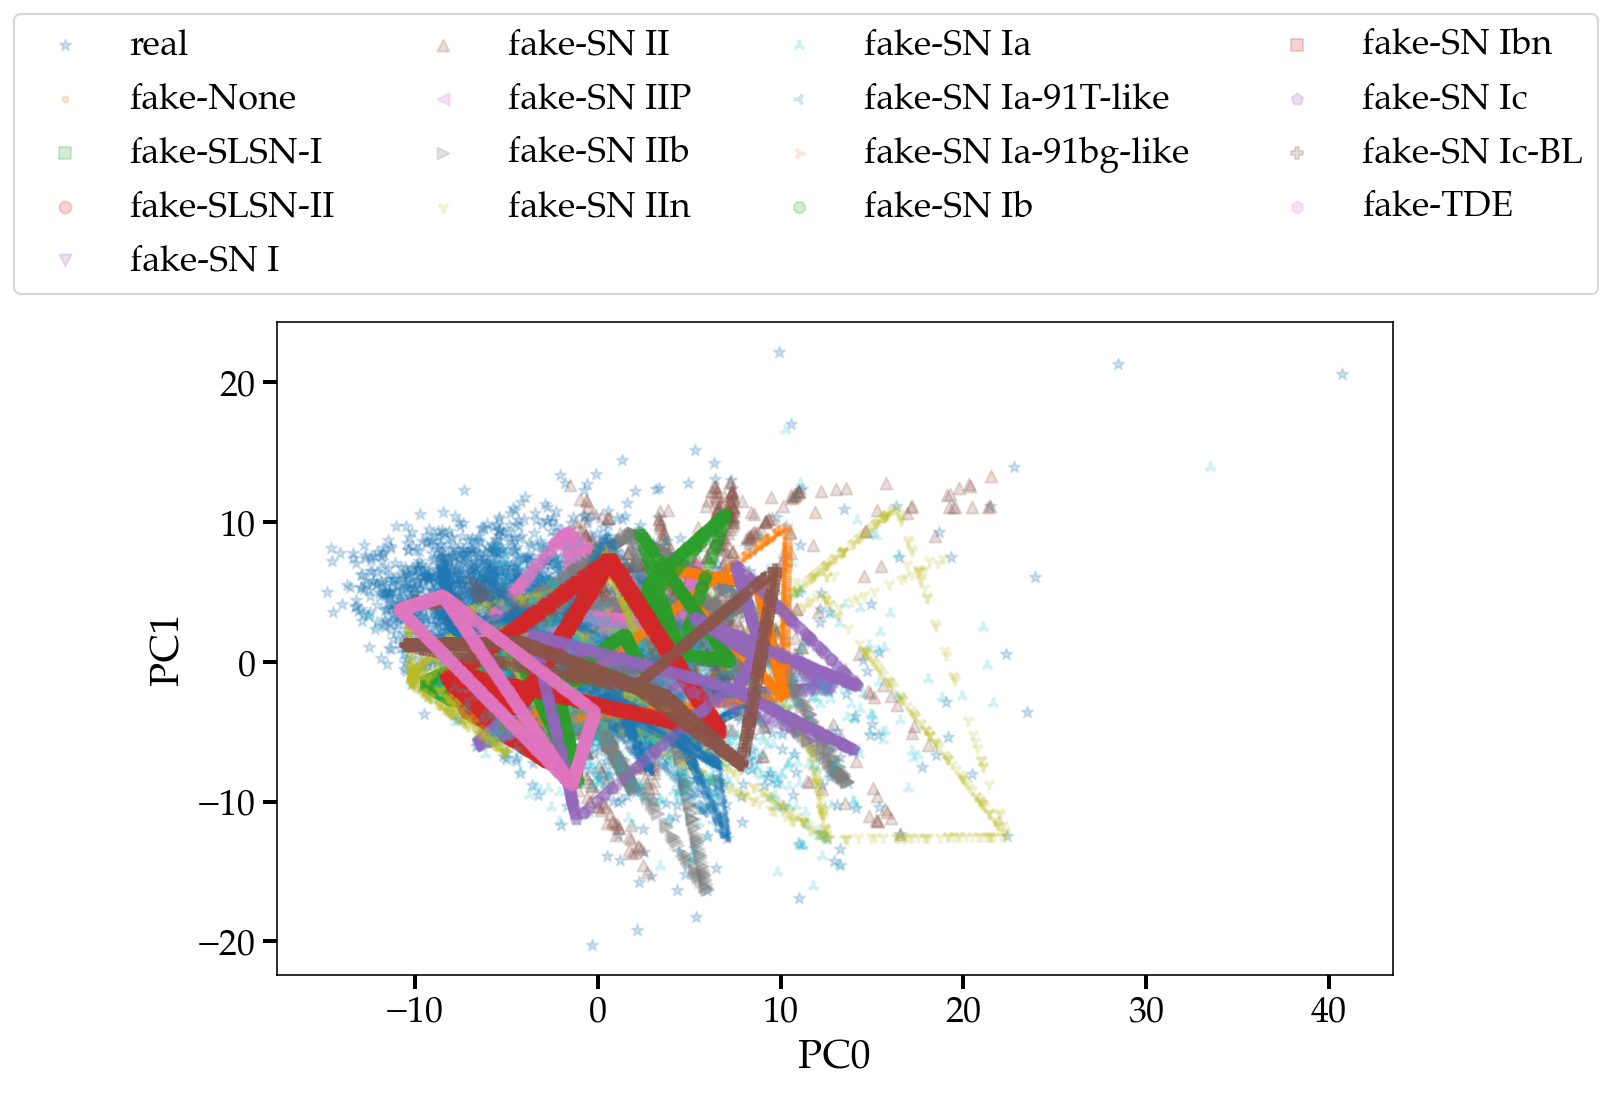

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

# Split into real/fakes
real_df = dataset_bank_pca[~dataset_bank_pca.index.str.startswith('ZTFabc')]
fakes_df = dataset_bank_pca[dataset_bank_pca.index.str.startswith('ZTFabc')]

ax.scatter(real_df['PC0'], real_df['PC1'], alpha=0.2, marker='*',label='real')

marker_l = ['.', ',', 'o', 'v', '^','<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', 'h', "H", '+', "x", 'X', 'D', 'd', '|'] 
for marker, cls in zip(marker_l, np.unique(dataset_bank_pca.tns_cls)):
    fakes_cls_df = fakes_df[fakes_df.tns_cls == cls]
    ax.scatter(fakes_cls_df['PC0'], fakes_cls_df['PC1'], alpha=0.2, marker=marker, label=f'fake-{cls}')

plt.xlabel('PC0')
plt.ylabel('PC1')

plt.legend(ncol=4, bbox_to_anchor=(1.2, 1.5))

folder_path = f"../figures/principal_components/{suffix}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.savefig(f'../figures/principal_components/{suffix}/fakes_cls_df.jpg', dpi=250, bbox_inches='tight')
plt.show()

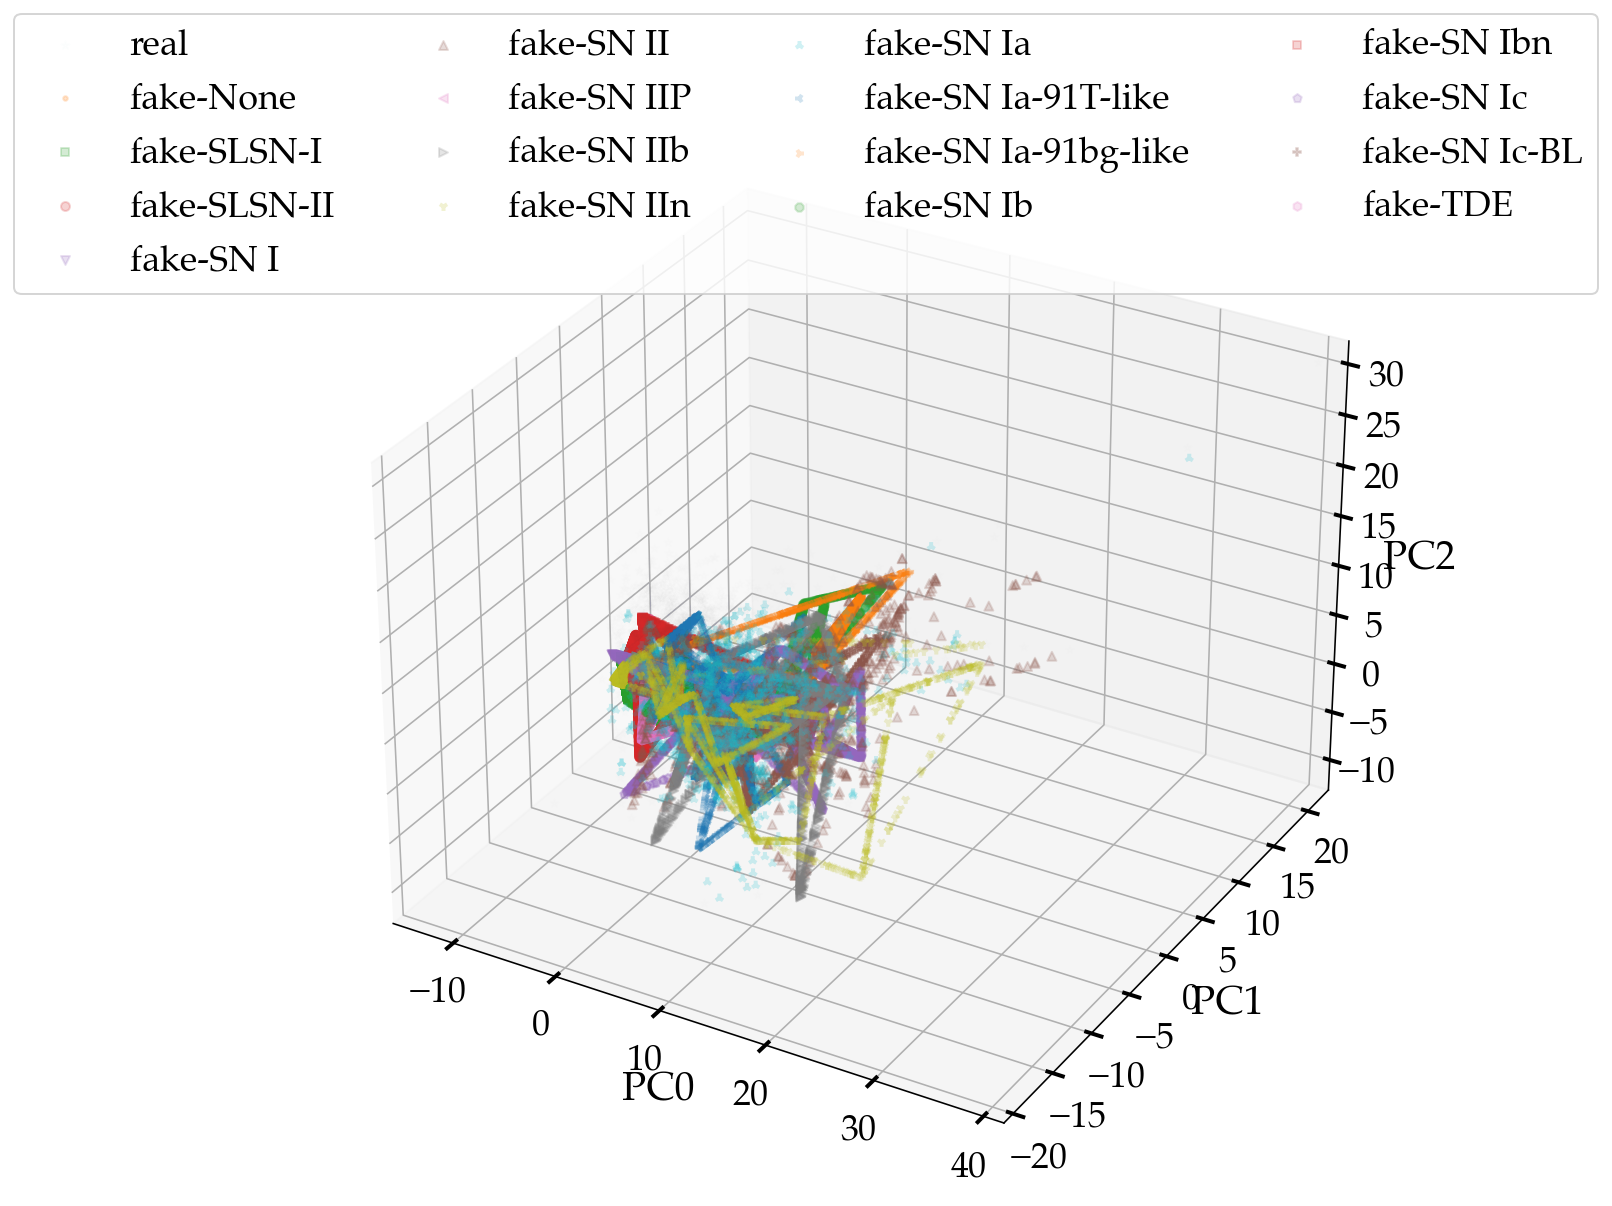

In [9]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Split into real/fakes
real_df = dataset_bank_pca[~dataset_bank_pca.index.str.startswith('ZTFabc')]
fakes_df = dataset_bank_pca[dataset_bank_pca.index.str.startswith('ZTFabc')]

ax.scatter(real_df['PC0'], real_df['PC1'], real_df['PC2'], alpha=0.005, marker='*',label='real')

marker_l = ['.', ',', 'o', 'v', '^','<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', 'h', "H", '+', "x", 'X', 'D', 'd', '|'] 
for marker, cls in zip(marker_l, np.unique(dataset_bank_pca.tns_cls)):
    fakes_cls_df = fakes_df[fakes_df.tns_cls == cls]
    ax.scatter(fakes_cls_df['PC0'], fakes_cls_df['PC1'], fakes_cls_df['PC2'], alpha=0.2, marker=marker, label=f'fake-{cls}')

# Set axis limits
ax.set_xlim(real_df['PC0'].min(), real_df['PC0'].max())
ax.set_ylim(real_df['PC1'].min(), real_df['PC1'].max())
ax.set_zlim(real_df['PC2'].min(), real_df['PC2'].max())    
    
ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')

plt.legend(ncol=4, bbox_to_anchor=(1.2, 1.1))

folder_path = f"../figures/principal_components/{suffix}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.savefig(f'../figures/principal_components/{suffix}/fakes_cls_df_3D.jpg', dpi=250, bbox_inches='tight')
plt.show()

In [10]:
# not upsampling None (no fakes), and few Ia fakes, so fakes doesn't cover all regions
# But fakes does cover outlier regions
# streaks are from extreme upsampling of O(few) instances of minority classes with 2knn

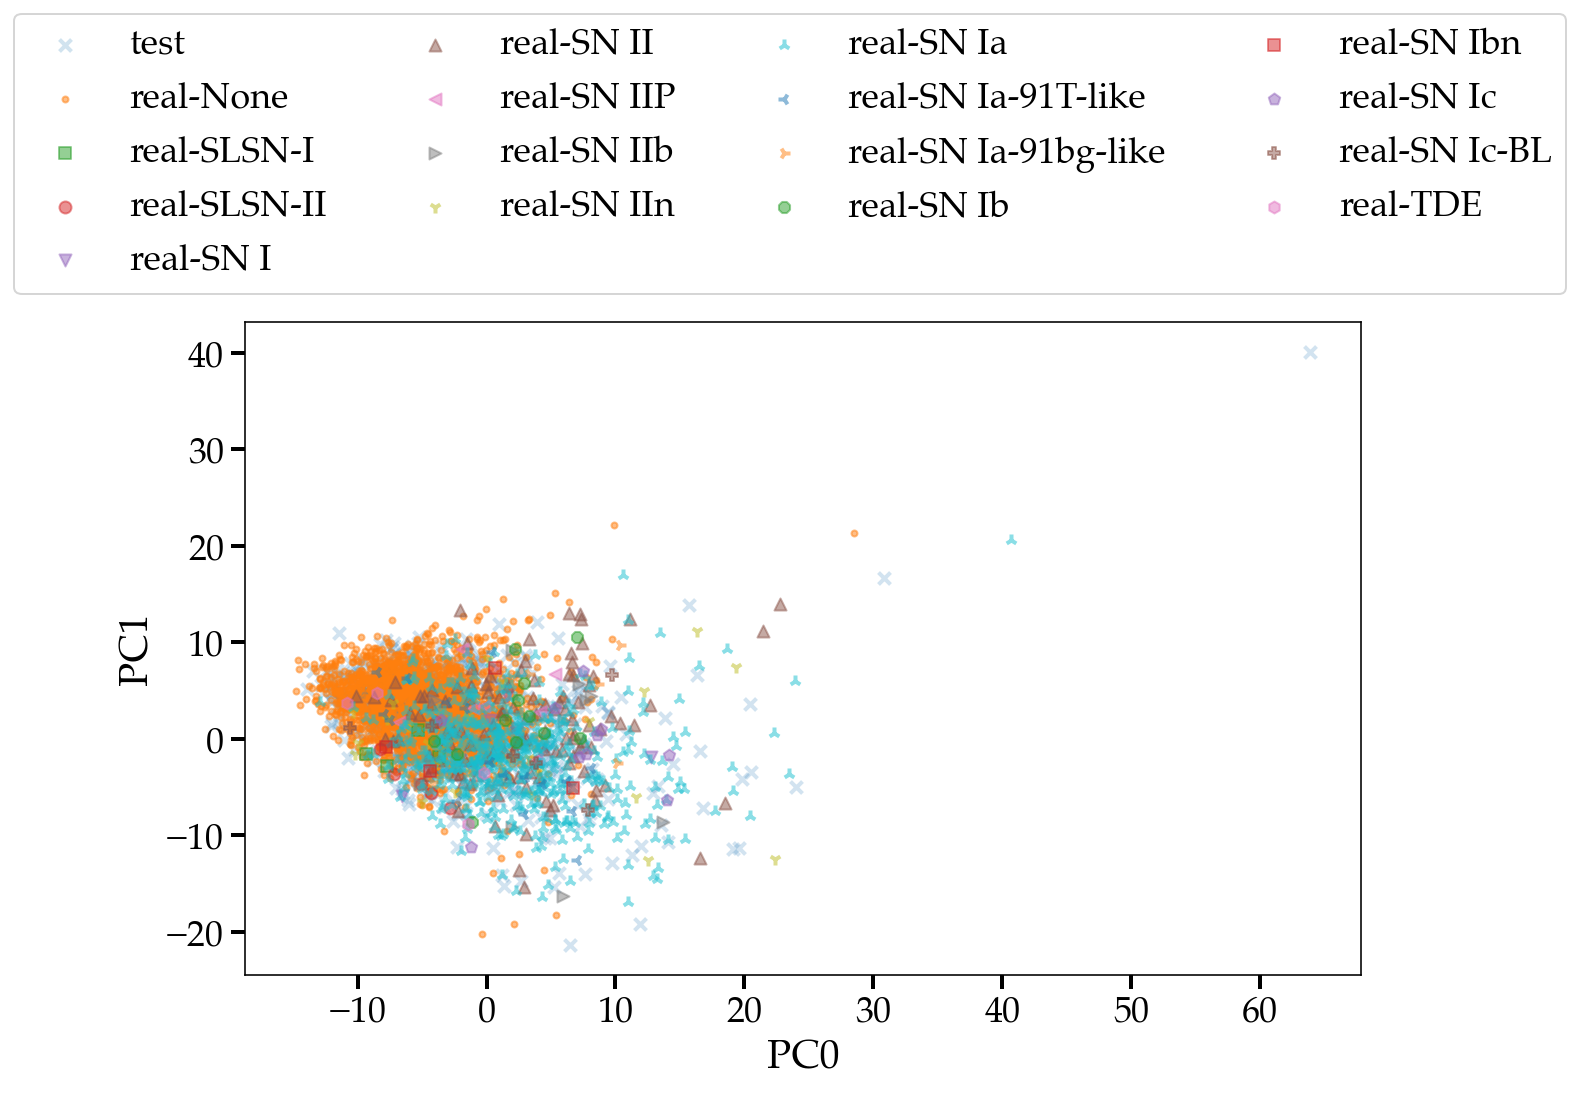

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

# Split into real/fakes
real_df = dataset_bank_pca[~dataset_bank_pca.index.str.startswith('ZTFabc')]
test_df = dataset_bank_test

ax.scatter(test_df['PC0'], test_df['PC1'], alpha=0.2, marker='x',label='test')


marker_l = ['.', ',', 'o', 'v', '^','<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', 'h', "H", '+', "x", 'X', 'D', 'd', '|'] 
for marker, cls in zip(marker_l, np.unique(dataset_bank_pca.tns_cls)):
    real_cls_df = real_df[real_df.tns_cls == cls]
    ax.scatter(real_cls_df['PC0'], real_cls_df['PC1'], alpha=0.5, marker=marker, label=f'real-{cls}')

#ax.scatter(real_df['PC0'], real_df['PC1'], alpha=0.2, marker='*',label='real')
#ax.scatter(test_df['PC0'], test_df['PC1'], alpha=0.05, marker='x',label='test')

plt.xlabel('PC0')
plt.ylabel('PC1')

plt.legend(ncol=4, bbox_to_anchor=(1.2, 1.5))
plt.savefig(f'../figures/principal_components/{suffix}/real_cls_df.jpg', dpi=250, bbox_inches='tight')
plt.show()

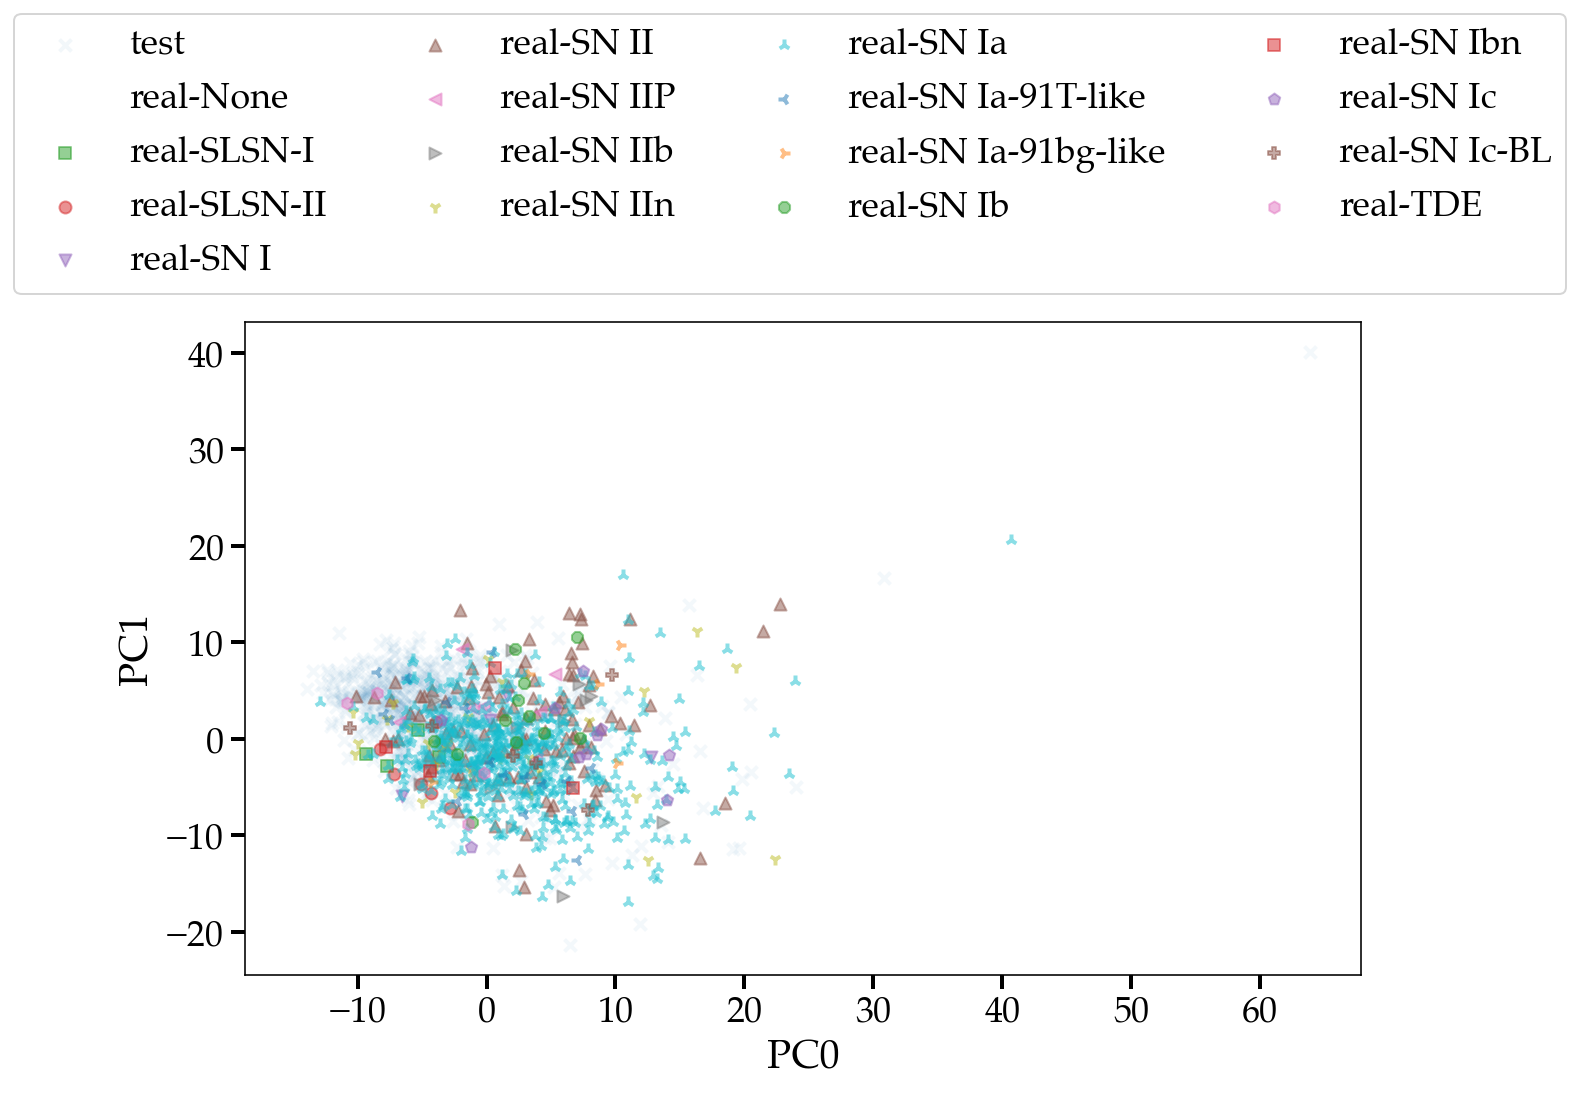

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

# Split into real/fakes
real_df = dataset_bank_pca[~dataset_bank_pca.index.str.startswith('ZTFabc')]
test_df = dataset_bank_test

ax.scatter(test_df['PC0'], test_df['PC1'], alpha=0.05, marker='x',label='test')


marker_l = ['.', ',', 'o', 'v', '^','<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', 'h', "H", '+', "x", 'X', 'D', 'd', '|'] 
for marker, cls in zip(marker_l, np.unique(dataset_bank_pca.tns_cls)):
    real_cls_df = real_df[real_df.tns_cls == cls]
    
    if cls == 'None': ax.scatter(real_cls_df['PC0'], real_cls_df['PC1'], alpha=0.0, marker=marker, label=f'real-{cls}')
    else: ax.scatter(real_cls_df['PC0'], real_cls_df['PC1'], alpha=0.5, marker=marker, label=f'real-{cls}')

#ax.scatter(real_df['PC0'], real_df['PC1'], alpha=0.2, marker='*',label='real')
#ax.scatter(test_df['PC0'], test_df['PC1'], alpha=0.05, marker='x',label='test')

plt.xlabel('PC0')
plt.ylabel('PC1')

plt.legend(ncol=4, bbox_to_anchor=(1.2, 1.5))
plt.savefig(f'../figures/principal_components/{suffix}/real_cls_df_no_real.jpg', dpi=250, bbox_inches='tight')
plt.show()

### Add convex hull

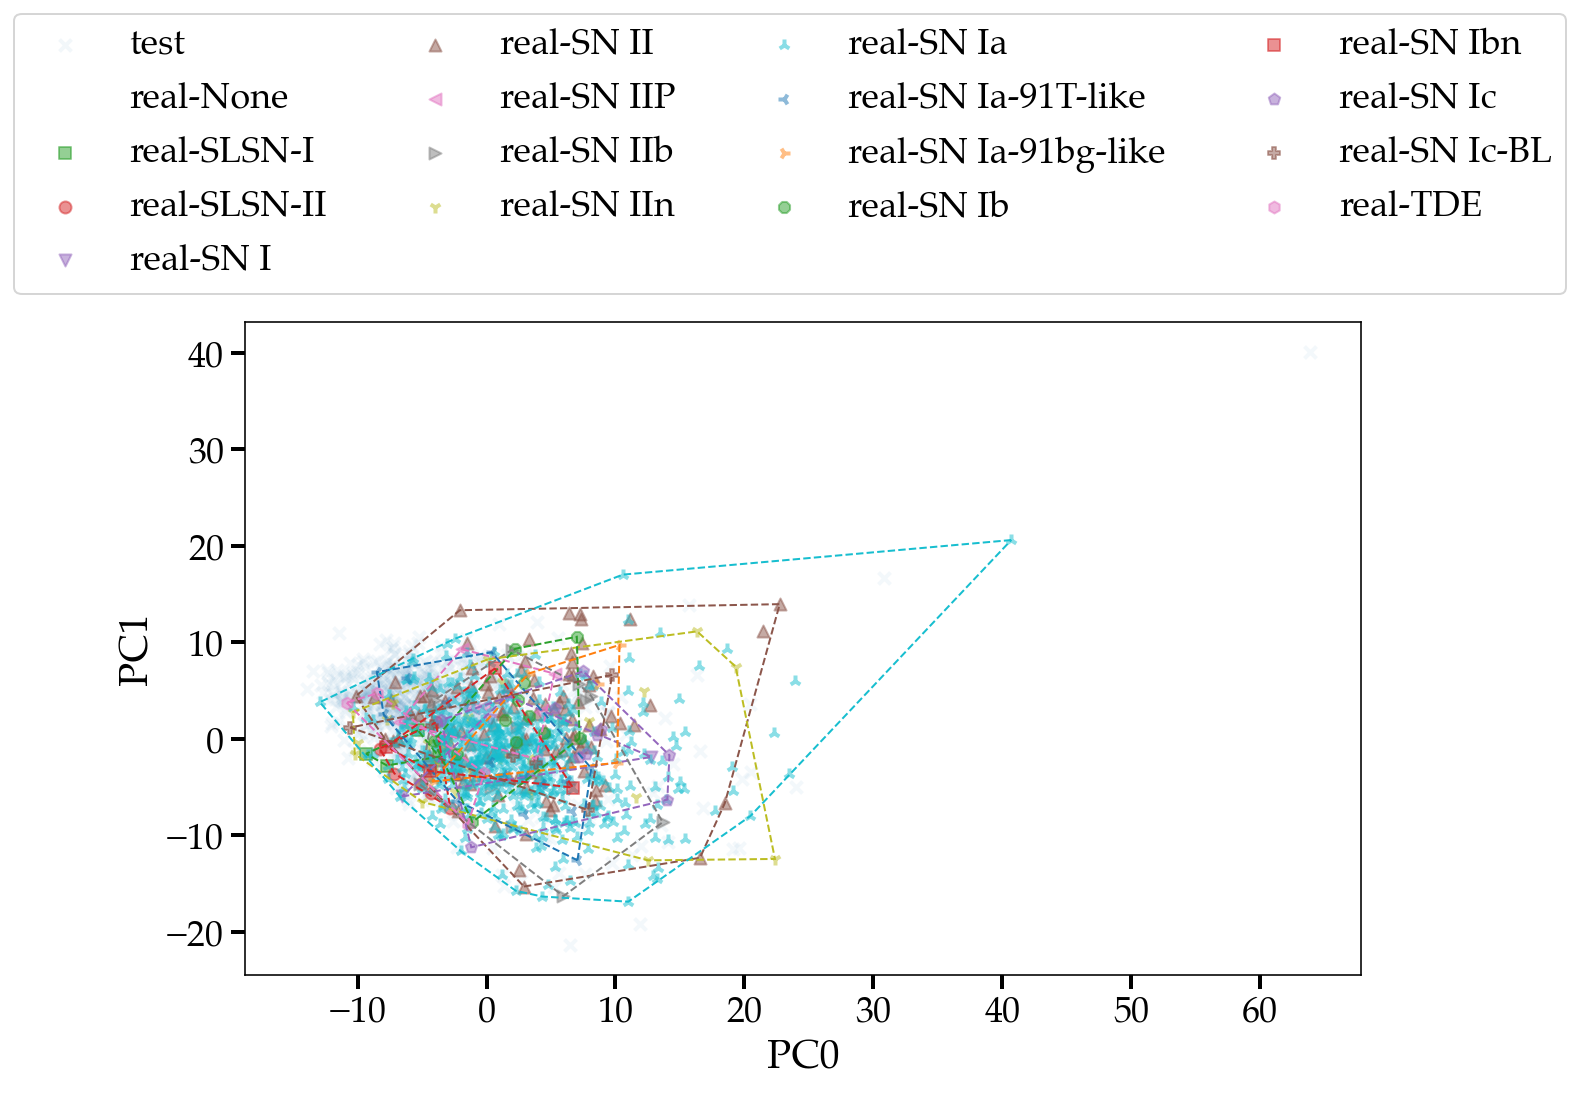

In [13]:
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))

# Split into real/fakes
real_df = dataset_bank_pca[~dataset_bank_pca.index.str.startswith('ZTFabc')]
test_df = dataset_bank_test

ax.scatter(test_df['PC0'], test_df['PC1'], alpha=0.05, marker='x', label='test')

marker_l = ['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', 'h', "H", '+', "x", 'X', 'D', 'd', '|']

for marker, cls in zip(marker_l, np.unique(dataset_bank_pca.tns_cls)):
    real_cls_df = real_df[real_df.tns_cls == cls]

    if cls == 'None':
        marker_color = ax.scatter(real_cls_df['PC0'], real_cls_df['PC1'], alpha=0.0, marker=marker, label=f'real-{cls}')
    else:
        marker_color = ax.scatter(real_cls_df['PC0'], real_cls_df['PC1'], alpha=0.5, marker=marker, label=f'real-{cls}').get_facecolor()[0]
        
        # Compute the convex hull
        points = np.column_stack([real_cls_df['PC0'], real_cls_df['PC1']])
        hull = ConvexHull(points)
        
        # Create the patch for the convex hull
        poly = Polygon(points[hull.vertices], edgecolor=marker_color, fill=False, linestyle='--', alpha=1)
        
        # Add the patch to the plot
        ax.add_patch(poly)

plt.xlabel('PC0')
plt.ylabel('PC1')

plt.legend(ncol=4, bbox_to_anchor=(1.2, 1.5))
plt.savefig(f'../figures/principal_components/{suffix}/real_cls_df_no_real_w_convex_hull.jpg', dpi=250, bbox_inches='tight')
plt.show()


# TODO: plot reals classes w/ convex hull and fakes w/ convex hull,
## See how good the overlap is. Do the same with test classes w/ convex hull and fakes w/ convex hull

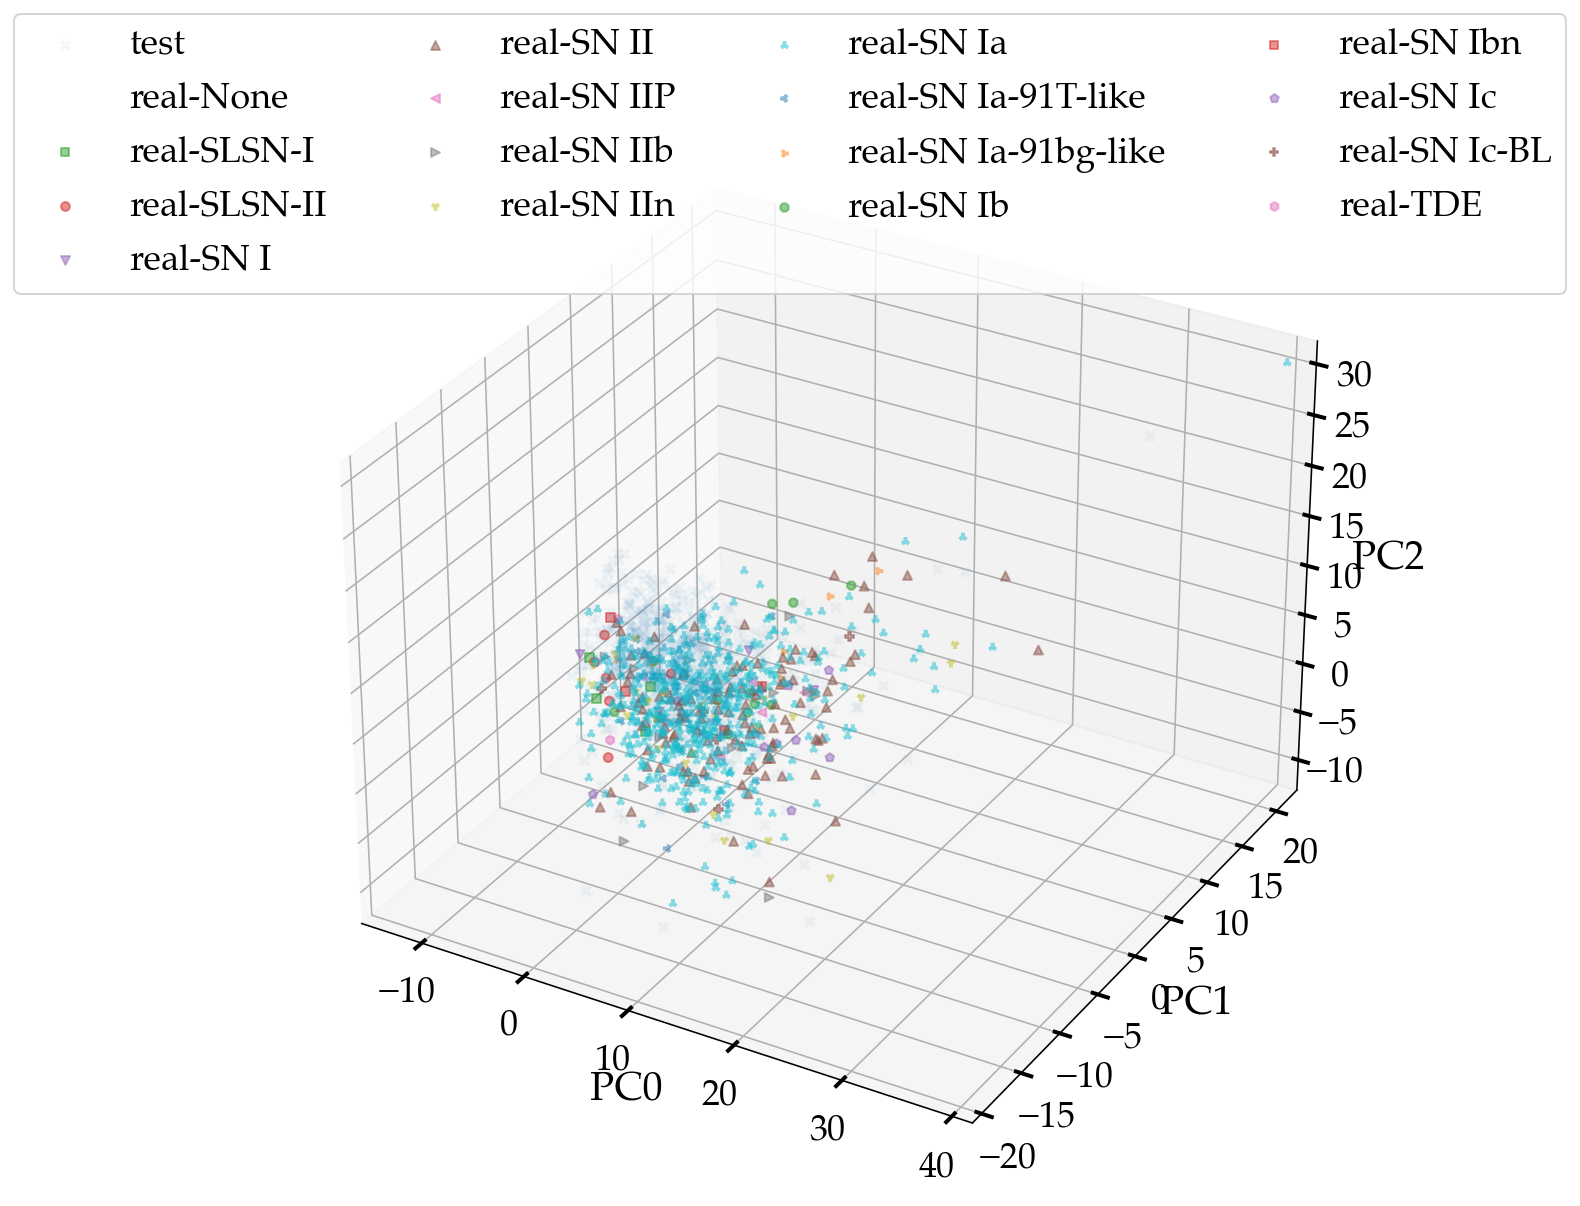

In [14]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Split into real/fakes
real_df = dataset_bank_pca[~dataset_bank_pca.index.str.startswith('ZTFabc')]
test_df = dataset_bank_test

ax.scatter(test_df['PC0'], test_df['PC1'], test_df['PC2'], alpha=0.05, marker='x', label='test')

marker_l = ['.', ',', 'o', 'v', '^','<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', 'h', "H", '+', "x", 'X', 'D', 'd', '|'] 
for marker, cls in zip(marker_l, np.unique(dataset_bank_pca.tns_cls)):
    real_cls_df = real_df[real_df.tns_cls == cls]
    
    if cls == 'None': ax.scatter(real_cls_df['PC0'], real_cls_df['PC1'], real_cls_df['PC2'], alpha=0.0, marker=marker, label=f'real-{cls}')
    else: ax.scatter(real_cls_df['PC0'], real_cls_df['PC1'], real_cls_df['PC2'], alpha=0.5, marker=marker, label=f'real-{cls}')

# ax.scatter(real_df['PC0'], real_df['PC1'], real_df['PC2'], alpha=0.2, marker='*', label='real')
# ax.scatter(test_df['PC0'], test_df['PC1'], test_df['PC2'], alpha=0.05, marker='x', label='test')

# Set axis limits
ax.set_xlim(real_df['PC0'].min(), real_df['PC0'].max())
ax.set_ylim(real_df['PC1'].min(), real_df['PC1'].max())
ax.set_zlim(real_df['PC2'].min(), real_df['PC2'].max())

ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')

plt.legend(ncol=4, bbox_to_anchor=(1.2, 1.1))
plt.savefig(f'../figures/principal_components/{suffix}/real_cls_df_no_real_3D.jpg', dpi=250, bbox_inches='tight')
plt.show()


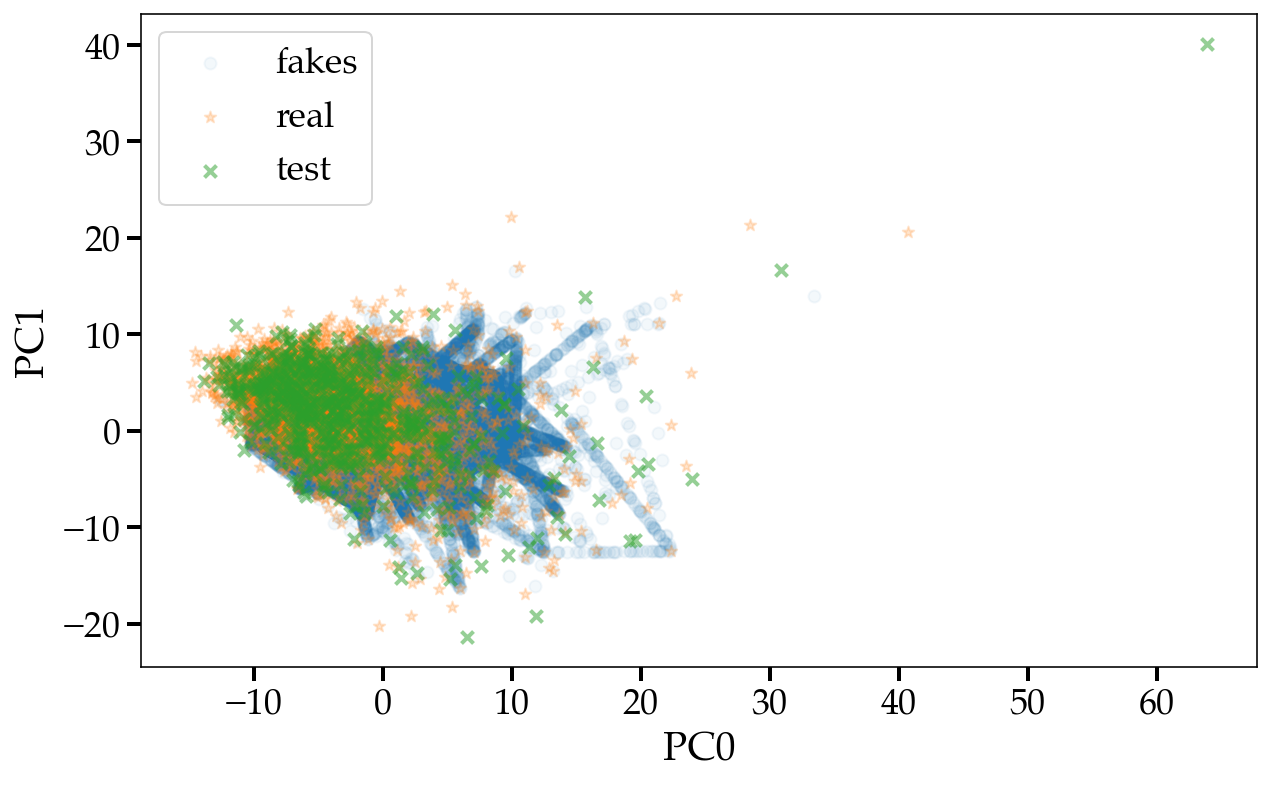

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

# Split into real/fakes
real_df = dataset_bank_pca[~dataset_bank_pca.index.str.startswith('ZTFabc')]
fakes_df = dataset_bank_pca[dataset_bank_pca.index.str.startswith('ZTFabc')]
test_df = dataset_bank_test

ax.scatter(fakes_df['PC0'], fakes_df['PC1'], alpha=0.05, marker='o', label='fakes')
ax.scatter(real_df['PC0'], real_df['PC1'], alpha=0.2, marker='*',label='real')
ax.scatter(test_df['PC0'], test_df['PC1'], alpha=0.5, marker='x',label='test')

plt.xlabel('PC0')
plt.ylabel('PC1')


folder_path = f"../figures/principal_components/{suffix}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.legend()
plt.savefig(f'../figures/principal_components/{suffix}/real_vs_fakes_vs_test.jpg', dpi=250, bbox_inches='tight')
plt.show()

In [16]:
#cut_df = test_df[(test_df['PC0'] > 4)]
cut_df = real_df[(real_df['PC0'] > 30)]

cut_df

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,tns_cls
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acynjjo,40.690495,20.599594,31.309608,36.498637,13.701949,3.871391,14.272962,-9.718038,12.056522,10.421309,...,1.093069,-0.404663,1.995408,0.413243,3.305241,2.453166,1.048379,1.264492,3.827271,SN Ia


In [17]:
for sn, cl in zip(cut_df.index, cut_df.tns_cls):
    print(f'https://alerce.online/object/{sn}', cl)

https://alerce.online/object/ZTF20acynjjo SN Ia


In [18]:
test_df[(test_df['PC0'] > 40)]

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,tns_cls
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acyroek,63.88625,40.106826,35.538718,46.917898,30.572287,-12.616237,-12.566339,10.807976,2.184879,17.071193,...,1.07258,41.455622,-3.46459,-59.067248,-59.49637,-33.813648,51.442429,-23.644487,18.47151,None


In [19]:
#suffix="noTNScut_pca45_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_MI_classif_LConly_hostdownweighted_SMOTE_80-20"

In [20]:
# train/test before smote has same embedding mostly
# smote covers regions it's supposed to

In [15]:
test_df[(test_df['PC0'] > 20) & (test_df['PC1'] < -20)]

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,tns_cls
ztf_object_id,,,,,,,,,,,,,,,,,,,,,


In [10]:
# https://alerce.online/object/ZTF18abdhozj - remaining periodic var
# https://alerce.online/object/ZTF20acqucpz - remaining CV

In [12]:
real_df[(real_df['PC0'] < -20) & (real_df['PC1'] > 15)]

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21abdtkdc,-22.163253,22.511544,-7.627958,-2.259726,-3.433426,-2.808574,-4.373169,0.230342,6.517101,-1.174292,...,1.207785,-0.965603,2.253548,1.345902,-2.990527,-1.364164,-2.640205,0.319725,-1.411165,-0.142190
ZTF21aarvysz,-20.838052,19.716343,-11.223825,-9.730916,-4.214124,-2.776630,-2.469222,4.432431,3.459800,-0.015755,...,-0.822607,0.529747,2.099676,0.324822,-0.193822,-0.413322,-3.663055,1.086797,-0.874276,-0.521186
ZTF21aardzlu,-20.609653,17.887838,-1.452162,-1.571780,5.446219,-0.511114,-2.816245,-0.564413,3.411933,1.063307,...,0.949911,-0.015324,-1.113844,-0.854960,0.542895,-1.589053,-0.632498,0.795945,-1.980645,-0.460658


In [ ]:
# all 3 are flat LCs with None tns spec class

In [14]:
test_df[(test_df['PC0'] < 10) & (test_df['PC1'] > 20)]

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF18abwxrhi,4.527623,21.511848,18.555454,11.050699,4.83806,-4.791629,21.238319,19.539585,-4.750731,-5.895489,...,-2.344125,-2.972335,3.366347,-0.763277,-1.839438,-1.142456,3.152264,1.380873,2.985124,3.431534


In [ ]:
# https://alerce.online/object/ZTF18abwxrhi
# that weird maybe double peak SN / bogus second bump obs

In [16]:
test_df[(test_df['PC0'] < -25) & (test_df['PC1'] < -10)]

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF18aaqdlle,-29.344679,-11.608744,10.294377,-2.510227,26.038514,2.667018,0.422067,5.172922,3.517185,-0.851667,...,-2.391525,-1.821549,-0.830398,-0.426677,0.503373,0.106479,-1.140716,0.549167,-2.004430,1.444579
ZTF18acclacc,-29.015988,-16.451279,5.987124,1.856043,21.864505,-1.625007,3.249946,9.712309,5.493366,2.360775,...,-2.382828,0.074992,0.530949,-1.617456,-0.956524,-2.599603,-0.943605,0.078554,-2.304119,0.805382


In [ ]:
# SN in template images

In [17]:
test_df[(test_df['PC0'] < -20) & (test_df['PC1'] < -10)]

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aasttsm,-20.298472,-11.896813,11.995602,-11.060080,1.215294,-1.563570,-3.610145,-6.124563,1.568291,3.397161,...,2.120320,1.851662,0.597470,0.474003,-1.956241,0.637700,1.965622,3.005612,-1.149632,-0.702561
ZTF21abrduyv,-24.222897,-14.482757,9.234705,3.250013,3.324799,1.948191,-2.928338,0.997722,-3.465844,0.748486,...,1.806170,0.148293,-2.418226,1.868700,-3.024807,0.368600,0.244908,-0.247381,0.245462,1.318686
ZTF21aaqhxvc,-22.256702,-14.075184,3.824647,7.586351,3.233600,-0.435544,1.882573,-0.221733,2.065071,-0.445902,...,-0.848070,0.833937,-3.098243,-0.176281,0.424199,0.163895,1.152259,-1.147861,-0.593108,1.061885
ZTF18aaqdlle,-29.344679,-11.608744,10.294377,-2.510227,26.038514,2.667018,0.422067,5.172922,3.517185,-0.851667,...,-2.391525,-1.821549,-0.830398,-0.426677,0.503373,0.106479,-1.140716,0.549167,-2.004430,1.444579
ZTF18acclacc,-29.015988,-16.451279,5.987124,1.856043,21.864505,-1.625007,3.249946,9.712309,5.493366,2.360775,...,-2.382828,0.074992,0.530949,-1.617456,-0.956524,-2.599603,-0.943605,0.078554,-2.304119,0.805382
ZTF21abcwnub,-20.716612,-10.193120,2.729436,-3.701176,0.192830,-1.169605,-1.817422,1.924119,-2.593268,-0.191790,...,0.801612,-0.347447,-1.637663,0.352083,-1.687103,-0.606164,1.077189,-0.676988,0.659723,-1.162769


In [ ]:
# ALL ZTF21 LCs are rising and top out before 2nd peak, tightly sampled Ia in small elliptical galaxies

# 2 PCs (43% of variance) do pretty good job.